In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


from collections import OrderedDict
from typing import List
from scipy.io import loadmat
from time import ctime

import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
matlab_data = loadmat("Project_IV_Data.mat")

u_bc_cases = matlab_data['u_bc']
u_data_cases = matlab_data['u_data']
v_data_cases = matlab_data['v_data']
x_2d = matlab_data['x_2d']
y_2d = matlab_data['y_2d']


u_bc_cases = torch.from_numpy(u_bc_cases).float().to(device)
u_data_cases = torch.from_numpy(u_data_cases).float().to(device)
v_data_cases = torch.from_numpy(v_data_cases).float().to(device)
x_2d = torch.from_numpy(x_2d).float().to(device)
y_2d = torch.from_numpy(y_2d).float().to(device)

In [14]:
class DNN(torch.nn.Module):

    def __init__(self, layers: List[int]):
        super().__init__()
        
        # 网络深度和激活函数
        self.depth = len(layers) + 1
        self.activation = torch.nn.Tanh

        # 有序字典储存网络的各层结构
        layer_list = list()
        for i in range(len(layers)-1): 
            layer_list.append(
                (f'layer_{i}', torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
        layerDict = OrderedDict(layer_list)

        # 序列式构造神经网络
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x: torch.tensor):
        out = self.layers(x)
        return out

In [15]:
class DeepONet(nn.Module):

    def __init__(self, layer_size_branch, layer_size_trunk):
        super().__init__()

        # 主干网络和分支网络的结构
        self.layer_size_branch = layer_size_branch
        self.layer_size_trunk = layer_size_trunk
        self.branch_net = DNN(self.layer_size_branch)
        self.trunk_net = DNN(self.layer_size_trunk)

        self.loss_fun = lambda y_true, y_pred: torch.mean(torch.square(y_true - y_pred))

    def forward(self, x_branch, x_trunk):

        # 分支网络和主干网络分别做前向传播输出
        y_branch = self.branch_net(x_branch)
        y_trunk = self.trunk_net(x_trunk)
        
        # 主干网络和分支网络的输出进行内积 得到最终输出
        if y_branch.shape[-1] != y_trunk.shape[-1]:
            raise AssertionError(
                "Output sizes of branch net and trunk net do not match."
            )
        U = (y_branch[:, :5] * y_trunk[:, :5]).sum(dim=1, keepdim=True)  # 暂时没想好训练策略，试着同时训两个速度
        Y = (y_branch[:, 5:] * y_trunk[:, 5:]).sum(dim=1, keepdim=True)

        return torch.cat((U,Y), dim=1)

In [16]:
# 三元组数据集，分别为分支网络的输入（原函数在一些点的采样），主干网络的输入（变换函数的采样点坐标），和输出（变换函数的采样点结果
# 即： 边界函数的采样数据，内部流场的采样点坐标，内部流场的采样点速度
# 按照自己的理解，网络应该是可以预测个别点的速度的，所以主干网络的输入应该是具有灵活性，可以只输入一个点，而不是必须是整个流场的网格采样点的坐标
# 因此，主干网络的输入应该是两个节点，而分支网络的输入应该是完整的65个节点。
class TripleDataset(torch.utils.data.Dataset):
    
    def __init__(self, boundary_cases, coordiniates, velocity_field, device):
        self.device = device
        self.boundary_cases = torch.tensor(boundary_cases).float().to(self.device)   # 100*65
        self.coordiniates = torch.tensor(coordiniates).float().to(self.device)   # 65*65*2
        self.velocity_filed = torch.tensor(velocity_field).float().to(self.device)   # 100*65*65*2
    
    def __len__(self):
        return self.boundary_cases.shape[0] * self.coordiniates.shape[0] * self.coordiniates.shape[1]

    def __getitem__(self, index):
        case_index = index // (self.coordiniates.shape[0] * self.coordiniates.shape[1])
        x_index = (index % (self.coordiniates.shape[0] * self.coordiniates.shape[1])) // self.coordiniates.shape[1]
        y_index = (index % (self.coordiniates.shape[0] * self.coordiniates.shape[1])) % self.coordiniates.shape[1]
        return self.get(case_index, x_index, y_index)

    def get(self, case_index, x_index, y_index):
        return self.boundary_cases[case_index], self.coordiniates[x_index, y_index], self.velocity_filed[case_index, x_index, y_index]

    def getcase(self, single_case_index):
        case_index = torch.ones(self.coordiniates.shape[0] * self.coordiniates.shape[1], dtype=int) * single_case_index
        x_index = torch.arange(self.coordiniates.shape[0]).repeat(self.coordiniates.shape[1])
        y_index = torch.arange(self.coordiniates.shape[1]).repeat(self.coordiniates.shape[0])
        # x_index, y_index = torch.meshgrid(x_index, y_index)
        # print(case_index, x_index.shape, y_index.shape)
        return self.get(case_index, x_index, y_index)
        

In [17]:
# 只保留的源代码的主要功能部分
class Trainer(object):

    def __init__(self, model, device):
        self.model = model
        self.model.branch_net.to(device)
        self.model.trunk_net.to(device)
        self.device = device
        self.train_log = []
        self.trainloss_best = {"epoch": 0, "loss": 1e5}
        self.valloss_best = {"epoch": 0, "loss": 1e5}


class AdamTrainer(Trainer):

    def __init__(
        self, model: torch.nn.Module, learning_rate=1e-3
    ):
        super().__init__(model, device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    def train_one_batch_adam(self, U_train_batch, X_train, S_train_batch):
        self.optimizer.zero_grad()
        preds = self.model(U_train_batch, X_train)
        loss = self.model.loss_fun(S_train_batch, preds)
        loss.backward()
        self.optimizer.step()
        
        return loss

    def train_adam(self, dataloader, num_epoch=10):
        for epoch in range(num_epoch):
            print("--------------------------------------------------------------")
            for batch, (boundary_cases, coordiniates, velocity_field) in enumerate(dataloader):
                loss = self.train_one_batch_adam(boundary_cases, coordiniates, velocity_field)
                print(f"Epoch :{epoch:<6d} Batch: {batch:<6d} train loss: {loss:.3f}")
            self.train_log.append([epoch, batch, loss.cpu().detach().numpy()])

In [18]:
# 分支网络和主干网络的结构
# 分支网络接受函数，即边界条件的采样点结果， 65个点的水平速度
# 主干网络接受坐标，即变换函数的采样点坐标， 任意一个点的x，y坐标
# 输出为变换函数的采样点结果
onet = DeepONet([65, 10, 10], [2, 10, 10])

coordiniates = torch.stack((x_2d, y_2d), dim=2)
velocity_field = torch.stack((u_data_cases, v_data_cases), dim=3)

dataset = TripleDataset(boundary_cases=u_bc_cases,  # 100个case的边界条件
                coordiniates=coordiniates,  # 65*65个点的坐标
                velocity_field=velocity_field, # 100个case的65*65个点的速度
                device=device)

dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
trainer = AdamTrainer(onet)
trainer.train_adam(dataloader, num_epoch=1)
# case_index, x_index, y_index = 10, 4, 5
# boundary_cases, coordiniates, velocity_field = dataset.get(case_index, x_index, y_index)

/tmp/ipykernel_1945209/3597938053.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.boundary_cases = torch.tensor(boundary_cases).float().to(self.device)   # 100*65
/tmp/ipykernel_1945209/3597938053.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coordiniates = torch.tensor(coordiniates).float().to(self.device)   # 65*65*2
/tmp/ipykernel_1945209/3597938053.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.velocity_filed = torch.tensor(velocity_field).float().to(self.device)   # 100*65*65*2


--------------------------------------------------------------
Epoch :0      Batch: 0      train loss: 0.058
Epoch :0      Batch: 1      train loss: 0.057
Epoch :0      Batch: 2      train loss: 0.053
Epoch :0      Batch: 3      train loss: 0.055
Epoch :0      Batch: 4      train loss: 0.054
Epoch :0      Batch: 5      train loss: 0.057
Epoch :0      Batch: 6      train loss: 0.054


Epoch :0      Batch: 7      train loss: 0.049
Epoch :0      Batch: 8      train loss: 0.049
Epoch :0      Batch: 9      train loss: 0.046
Epoch :0      Batch: 10     train loss: 0.049
Epoch :0      Batch: 11     train loss: 0.048
Epoch :0      Batch: 12     train loss: 0.047
Epoch :0      Batch: 13     train loss: 0.046
Epoch :0      Batch: 14     train loss: 0.044
Epoch :0      Batch: 15     train loss: 0.044
Epoch :0      Batch: 16     train loss: 0.044
Epoch :0      Batch: 17     train loss: 0.042
Epoch :0      Batch: 18     train loss: 0.042
Epoch :0      Batch: 19     train loss: 0.047
Epoch :0      Batch: 20     train loss: 0.040
Epoch :0      Batch: 21     train loss: 0.041
Epoch :0      Batch: 22     train loss: 0.043
Epoch :0      Batch: 23     train loss: 0.043
Epoch :0      Batch: 24     train loss: 0.042
Epoch :0      Batch: 25     train loss: 0.041
Epoch :0      Batch: 26     train loss: 0.045
Epoch :0      Batch: 27     train loss: 0.041
Epoch :0      Batch: 28     train 

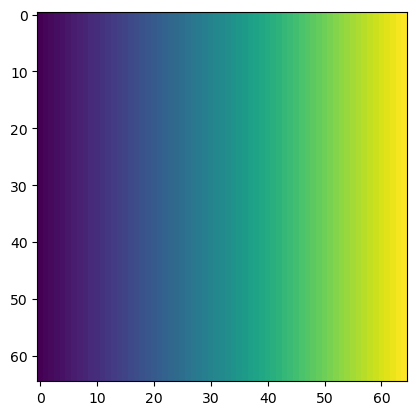

In [21]:
boundary_cases, coordiniates, velocity_field = dataset.getcase(0)
preds = trainer.model(boundary_cases, coordiniates)
plt.imshow(preds.cpu().detach().numpy().reshape(65,65,2)[:,:,0])

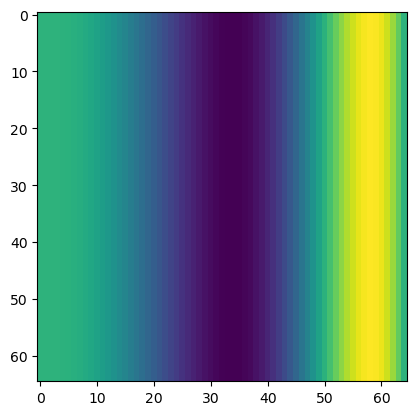

In [24]:
plt.imshow(velocity_field.cpu().detach().numpy().reshape(65,65,2)[:,:,0])

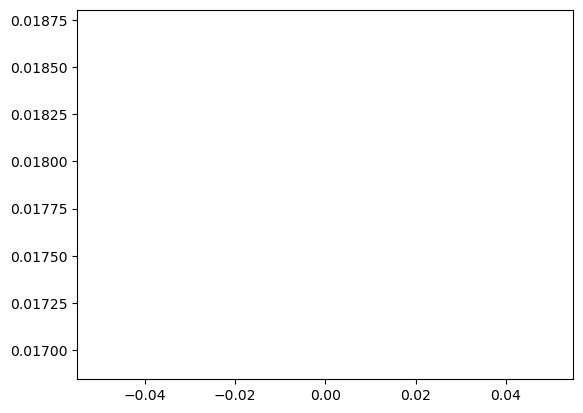

In [20]:
loss = np.array(trainer.train_log)[:, 2]
plt.plot(loss)